### **1. Business Context**

The hotel chain operates multiple bars across different locations. Each bar stocks various alcoholic beverage brands. Managing inventory is critical because:

* If a popular drink runs out → **Guests are disappointed** → Sales lost.
* If a slow-moving drink is overstocked → **Money gets locked in inventory** → Storage cost increases.

So the business needs a **balanced inventory system** that prevents both stockouts and overstocking.

---

### **2. What Is the Problem?**

Currently, inventory ordering is **not data-driven**.
Bar managers **do not have a reliable way to forecast how much of each drink will be consumed** in the future.

This leads to:

* **Stockouts** of high-demand items
* **Overstocking** of low-demand items
* **Higher operational cost**
* **Lower guest satisfaction**

---

### **3. What We Are Asked to Do (Objective)**

We are given **historical inventory movement data** with:

* Opening balance
* Purchases (received stock)
* Consumption
* Closing balance

Using this data, we must:

#### **Forecast future demand** for each item at each bar

(How much will be consumed in the next period)

#### **Recommend inventory levels (Par Levels)**

(This is how much stock a bar should always maintain)

#### **Simulate how this system would work in real operations**

(Show that stockouts reduce and wastage reduces)

---

### **4. What the Final Outcome Should Achieve**

* Bars always have enough stock of popular items
* Slow-moving items are not over-purchased
* Costs go down (less extra inventory)
* Guest satisfaction improves (no stockouts)

---

### **5. How to Start the Solution (Conceptual Plan — No coding yet)**

| Step       | Action                                  | Purpose                               |
| ---------- | --------------------------------------- | ------------------------------------- |
| **Step 1** | Analyze past consumption data           | Understand usage patterns             |
| **Step 2** | Forecast future consumption             | Predict demand                        |
| **Step 3** | Determine Par Level (Recommended stock) | Avoid stockouts & reduce excess stock |
| **Step 4** | Simulate future stock movement          | Validate system performance           |






In [2]:
# importing necessary libraries
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# BUSINESS PARAMETERS

LEAD_TIME_DAYS = 3
SERVICE_LEVEL = 0.95
SERVICE_Z = 1.65
Z_80 = 1.28
ORDER_COST = 25
HOLDING_COST_ANNUAL_RATE = 0.20
VALUE_PER_LITER = 50
HOLDING_COST_PER_ML = HOLDING_COST_ANNUAL_RATE * VALUE_PER_LITER / 365 / 1000

FALLBACK_MIN_HISTORY = 1
FALLBACK_SAFETY_BUFFER_DAYS = 1
FALLBACK_SERVICE_Z = 1.0

MIN_MODEL_HISTORY = 60

- Lead Time (LT) = 3 days → Demand is forecasted for the next 3 days only (DDLT).
- Par Level = Forecasted 3-Day Demand + Safety Stock.
- Safety Stock calculated using service level Z = 1.65 (95%).
- ML Models (XGBoost/Prophet) are only used when ≥ 60 days of historical data exists.
- Items with < 60 days use fallback mean + reduced safety buffer to avoid overstocking.


In [3]:
# Load data
df = pd.read_excel('/content/Consumption Dataset.xlsx', parse_dates=['Date Time Served'])
df.head()


,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,2023-01-01 13:53:00,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,2023-01-01 22:28:00,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date Time Served      6575 non-null   datetime64[ns]
 1   Bar Name              6575 non-null   object        
 2   Alcohol Type          6575 non-null   object        
 3   Brand Name            6575 non-null   object        
 4   Opening Balance (ml)  6575 non-null   float64       
 5   Purchase (ml)         6575 non-null   float64       
 6   Consumed (ml)         6575 non-null   float64       
 7   Closing Balance (ml)  6575 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 411.1+ KB




## **1. What Each Column Represents**

| Column                   | Meaning / Business Interpretation                                                                                                                         |
| ------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Date Time Served**     | The date and time when the drink transaction or inventory update was recorded. This allows us to track consumption **over time**.                         |
| **Bar Name**             | Identifies **which bar location** the stock movement is associated with. Each bar will have different demand patterns.                                    |
| **Alcohol Type**         | The broad category of drink (e.g., Rum, Whisky, Wine). Useful for grouping & aggregate trends.                                                            |
| **Brand Name**           | The **specific product** within the alcohol type (e.g., Captain Morgan, Kingfisher). This is the **unit level** at which demand forecasting will be done. |
| **Opening Balance (ml)** | Amount of that brand available **at the start of the day / shift**, measured in milliliters.                                                              |
| **Purchase (ml)**        | Quantity **added to stock** (restocked inventory) on that date/time.                                                                                      |
| **Consumed (ml)**        | Quantity **actually used / sold / served** to customers. This is the **key variable for demand forecasting**.                                             |
| **Closing Balance (ml)** | Quantity left **after consumption and purchases** at the end of the shift/day.                                                                            |






In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date Time Served,6575,NaN,NaN,NaN,2023-07-01 09:09:52.033459968,2023-01-01 10:07:00,2023-03-30 19:35:00,2023-06-30 18:08:00,2023-10-01 13:59:30,2024-01-01 22:46:00,NaN
Bar Name,6575,6,Johnson's Bar,1106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alcohol Type,6575,5,Vodka,1331,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand Name,6575,16,Yellow Tail,479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Opening Balance (ml),6575.0,NaN,NaN,NaN,2468.393518,0.0,619.135,1848.44,3853.02,11862.52,2284.556232
Purchase (ml),6575.0,NaN,NaN,NaN,315.841757,0.0,0.0,0.0,526.345,1999.84,582.120264
Consumed (ml),6575.0,NaN,NaN,NaN,299.419264,0.0,156.64,300.39,450.87,1180.58,191.903874
Closing Balance (ml),6575.0,NaN,NaN,NaN,2484.816011,0.0,611.0,1849.84,3906.05,11862.52,2302.362117


## What We Can Interpret from This Data

### **1. Time Coverage**

* **Date Time Served** ranges from **Jan 2023 to Jan 2024** → We have **one full year** of data, which is useful for understanding seasonal and monthly patterns.

---

### **2. Number of Bars and Variety of Inventory**

* **Bar Name:** There are **6 different bars**.

  * Most activity comes from **Johnson's Bar** (freq = 1106 records).

* This means **demand varies by location** and we cannot treat all bars the same.

* **Alcohol Type:** Only **5 alcohol categories**.

  * Most common is **Vodka** (1331 records).

* Suggests Vodka may be a **high-demand category**.

* **Brand Name:** There are **16 brands**.

  * Most frequent brand is **Yellow Tail** (479 records).

* Indicates some brands are **much more popular** than others.

---

### **3. Stock and Consumption Patterns**

| Metric                                 | Interpretation                                                                          |
| -------------------------------------- | --------------------------------------------------------------------------------------- |
| **Opening Balance Mean ≈ 2468 ml**     | Bars generally start the day with a moderate stock level.                               |
| **Huge range (0 ml to 11862 ml)**      | Some items get **overstocked heavily**, others get **completely depleted** (stockouts). |
| **Most days Purchase = 0 ml (median)** | Bars **do not restock daily**. They wait and restock in **large batches** instead.      |
| **Max Purchase ≈ 2000 ml**             | When they do restock, they **order a lot at once**.                                     |
| **Median Consumed ≈ 300 ml**           | On a typical day, ~300 ml of a product is used.                                         |
| **Max Consumed ≈ 1180 ml**             | Some days have **very high demand spikes**. This explains **stockouts**.                |

---

### **4. Stockouts are Real**

* Minimum opening and closing balance is **0 ml**, meaning:

  * **Products did run out at times** → confirms the **business problem**.





In [6]:
# Standardize column names
df.columns = ['datetime', 'bar', 'alcohol_type', 'brand', 'opening_ml', 'purchase_ml', 'consumed_ml', 'closing_ml']
print(f"Loaded {len(df)} rows from {df['bar'].nunique()} bars")
print(f"Date range: {df['datetime'].min()} → {df['datetime'].max()}")
df.head(3)


Loaded 6575 rows from 6 bars
Date range: 2023-01-01 10:07:00 → 2024-01-01 22:46:00


,datetime,bar,alcohol_type,brand,opening_ml,purchase_ml,consumed_ml,closing_ml
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28


### Data Validation & Cleaning



In [7]:
# Current stock
df_current_stock = df.sort_values('datetime', ascending=False).drop_duplicates(
    subset=['bar', 'brand']
)[['bar', 'brand', 'closing_ml']].rename(columns={'closing_ml': 'current_stock_ml'})
df_current_stock.head(3)

,bar,brand,current_stock_ml
6573,Thomas's Bar,Absolut,2296.43
6574,Thomas's Bar,Bacardi,2401.21
6571,Anderson's Bar,Malibu,1568.59


In [8]:
# VALIDATE INVENTORY LOGIC

df['calculated_closing'] = df['opening_ml'] + df['purchase_ml'] - df['consumed_ml']
df['error'] = np.abs(df['closing_ml'] - df['calculated_closing'])

print(f"Max accounting error: {df['error'].max():.2f} ml")
print(f"Rows with error > 1ml: {(df['error'] > 1).sum()}")

# Keep only valid rows
df = df[df['error'] <= 1].copy()
df = df.drop(columns=['error', 'calculated_closing'])

print(f"Clean data: {len(df)} rows")



Max accounting error: 0.00 ml
Rows with error > 1ml: 0
Clean data: 6575 rows


### Aggregate to Daily Demand

In [9]:
# Daily aggregation
df['date'] = df['datetime'].dt.date
daily = df.groupby(['bar', 'brand', pd.to_datetime(df['date'])]).agg({
    'consumed_ml': 'sum'
}).reset_index().rename(columns={'consumed_ml': 'y', 'date': 'ds'})
daily.head(3)

,bar,brand,ds,y
0,Anderson's Bar,Absolut,2023-01-02,118.62
1,Anderson's Bar,Absolut,2023-01-05,463.20
2,Anderson's Bar,Absolut,2023-01-06,453.02


In [10]:
daily['item_key'] = daily['bar'] + '_' + daily['brand']
daily = daily.sort_values(['item_key', 'ds']).reset_index(drop=True)
daily.head(3)

,bar,brand,ds,y,item_key
0,Anderson's Bar,Absolut,2023-01-02,118.62,Anderson's Bar_Absolut
1,Anderson's Bar,Absolut,2023-01-05,463.20,Anderson's Bar_Absolut
2,Anderson's Bar,Absolut,2023-01-06,453.02,Anderson's Bar_Absolut


### Feature Engineering

In [11]:
# FEATURE ENGINEERING FOR FORECASTING
def create_features(data):
    df = data.copy()
    df['dow'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)  # Sat=5, Sun=6
    df['day_of_year'] = df['ds'].dt.dayofyear

    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df.groupby('item_key')['y'].shift(lag)

    df['roll_mean_7'] = df.groupby('item_key')['y'].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    return df

daily_feat = create_features(daily)
daily_feat = daily_feat.dropna().reset_index(drop=True)

## Feature Engineering for EDA

In [12]:

df['date'] = df['datetime'].dt.date
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_month'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['week_of_year'] = df['datetime'].dt.isocalendar().week
df['hour'] = df['datetime'].dt.hour


df['is_weekend'] = df['day_of_week'].isin([4, 5, 6]).astype(int)

# Create day name for better understanding
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_name'] = df['day_of_week'].apply(lambda x: day_names[x])

print("\nFeatures created:")
print("- day_of_week: 0=Monday, 6=Sunday")
print("- day_of_month: Day of the month (1-31)")
print("- month: Month of the year (1-12)")
print("- week_of_year: Week number in the year")
print("- is_weekend: 1 if Friday/Saturday/Sunday, 0 otherwise")
print("- hour: Hour of the day")



Features created:
- day_of_week: 0=Monday, 6=Sunday
- day_of_month: Day of the month (1-31)
- month: Month of the year (1-12)
- week_of_year: Week number in the year
- is_weekend: 1 if Friday/Saturday/Sunday, 0 otherwise
- hour: Hour of the day


Average Consumption by Day of Week:
day_name
Monday       289.015411
Tuesday      298.122761
Wednesday    311.683543
Thursday     297.083294
Friday       302.749509
Saturday     299.598820
Sunday       297.700979
Name: consumed_ml, dtype: float64
Average Consumption by Bar:
bar
Johnson's Bar     311.197450
Smith's Bar       304.929416
Anderson's Bar    304.735889
Brown's Bar       296.701745
Taylor's Bar      289.684338
Thomas's Bar      289.206122
Name: consumed_ml, dtype: float64
Top 10 Most Consumed Brands (Total):
bar
Johnson's Bar     344184.38
Anderson's Bar    335818.95
Smith's Bar       328713.91
Brown's Bar       326371.92
Thomas's Bar      318415.94
Taylor's Bar      315176.56
Name: consumed_ml, dtype: float64
Visualization saved as 'consumption_analysis.png'


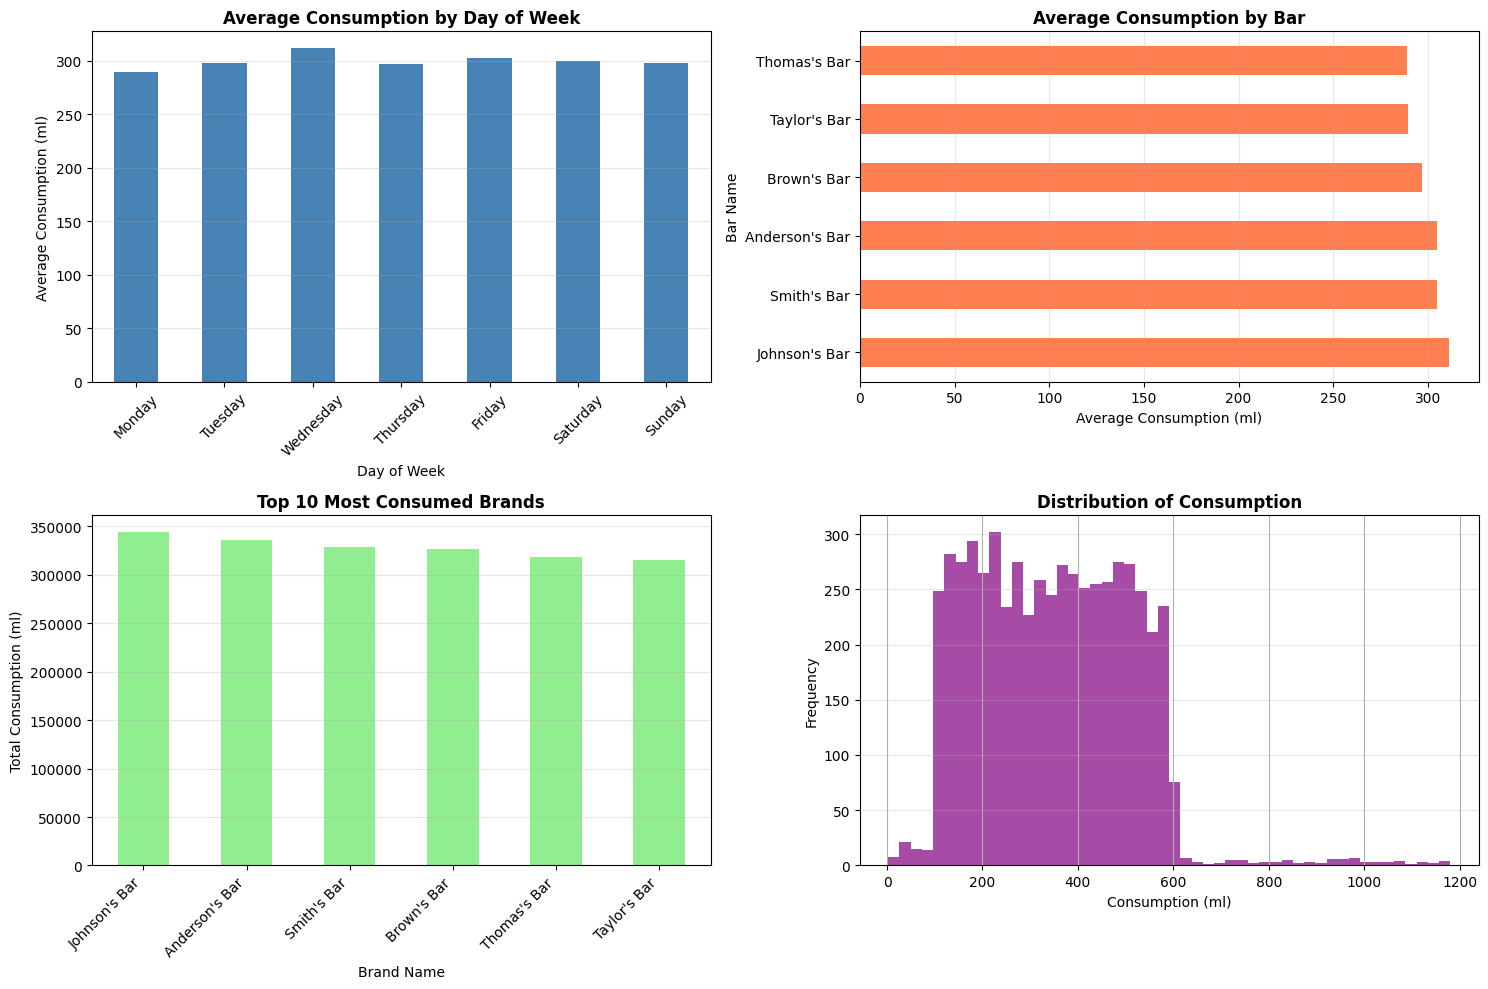

In [13]:
# EDA

# Average consumption by day of week
avg_by_day = df.groupby('day_name')['consumed_ml'].mean().reindex(day_names)
print("Average Consumption by Day of Week:")
print(avg_by_day)

# Average consumption by bar
avg_by_bar = df.groupby('bar')['consumed_ml'].mean().sort_values(ascending=False)
print("Average Consumption by Bar:")
print(avg_by_bar)

# Top 10 most consumed brands
top_brands = df.groupby('bar')['consumed_ml'].sum().sort_values(ascending=False).head(10)
print("Top 10 Most Consumed Brands (Total):")
print(top_brands)

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Consumption by Day of Week
plt.subplot(2, 2, 1)
avg_by_day.plot(kind='bar', color='steelblue')
plt.title('Average Consumption by Day of Week', fontsize=12, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption (ml)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Plot 2: Consumption by Bar
plt.subplot(2, 2, 2)
avg_by_bar.plot(kind='barh', color='coral')
plt.title('Average Consumption by Bar', fontsize=12, fontweight='bold')
plt.xlabel('Average Consumption (ml)')
plt.ylabel('Bar Name')
plt.grid(axis='x', alpha=0.3)

# Plot 3: Top 10 Brands
plt.subplot(2, 2, 3)
top_brands.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Most Consumed Brands', fontsize=12, fontweight='bold')
plt.xlabel('Brand Name')
plt.ylabel('Total Consumption (ml)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Plot 4: Consumption Distribution
plt.subplot(2, 2, 4)
df[df['consumed_ml'] > 0]['consumed_ml'].hist(bins=50, color='purple', alpha=0.7)
plt.title('Distribution of Consumption', fontsize=12, fontweight='bold')
plt.xlabel('Consumption (ml)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('consumption_analysis.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'consumption_analysis.png'")

### Preparing Data For DUAL-MODEL TRAINING AND SELECTION

### Train  XGBoost Regressor


In [14]:
# Time-based split: last 30 days for validation
split_date = daily_feat['ds'].max() - timedelta(days=30)
train_df = daily_feat[daily_feat['ds'] <= split_date]
test_df = daily_feat[daily_feat['ds'] > split_date]

RF_FEATURES = [c for c in daily_feat.columns if c not in ['y', 'ds', 'bar', 'brand', 'item_key']]

xgb = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, n_jobs=-1, random_state=42)
xgb.fit(train_df[RF_FEATURES], train_df['y'])

# Per-item MAE
xgb_mae_per_item = {}
for key, group in test_df.groupby('item_key'):
    if len(group) == 0: continue
    pred = xgb.predict(group[RF_FEATURES])
    xgb_mae_per_item[key] = mean_absolute_error(group['y'], pred)

In [33]:


# # 1. Uninstall any remaining conflicting packages
# print("Uninstalling old prophet versions...")
# !pip uninstall -y prophet pystan fbprophet

# # 2. Install cmdstanpy (the modern Stan backend)
# # This is a lighter, more stable dependency.
# print("Installing cmdstanpy...")
# !pip install cmdstanpy

# # 3. Install Prophet
# # This version will automatically detect and use cmdstanpy.
# print("Installing prophet...")
# !pip install prophet

# # 4. Verification (Optional)
# try:
#     from prophet import Prophet
#     print("Prophet module loaded successfully.")
# except Exception as e:
#     print(f"Verification failed: {e}")

# IMPORTANT: After this cell completes, you MUST restart the runtime/kernel
print("\n********************************************************")
print("  RESTART YOUR RUNTIME/KERNEL NOW to complete the fix!  ")
print("********************************************************")

Uninstalling old prophet versions...
Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Installing cmdstanpy...
Installing prophet...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 83.8 MB/s eta 0:00:00


Prophet module loaded successfully.

********************************************************
  RESTART YOUR RUNTIME/KERNEL NOW to complete the fix!  
********************************************************


### Train Smart Prophet Per Item

In [15]:
prophet_models = {}
prophet_mae_per_item = {}

for key, group in daily.groupby('item_key'):
    if len(group) < MIN_MODEL_HISTORY:
        prophet_mae_per_item[key] = np.inf
        continue

    df_p = group[['ds', 'y']].copy()
    df_p['is_weekend'] = df_p['ds'].dt.weekday.isin([5,6]).astype(int)
    df_p['lag_7'] = df_p['y'].shift(7)
    df_p = df_p.dropna()

    if len(df_p) < 50:
        prophet_mae_per_item[key] = np.inf
        continue

    split_idx = int(len(df_p) * 0.8)
    train_p, test_p = df_p.iloc[:split_idx], df_p.iloc[split_idx:]

    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.add_regressor('is_weekend')
    m.add_regressor('lag_7')
    m.fit(train_p)

    future = test_p[['ds', 'is_weekend']].copy()
    future['lag_7'] = list(train_p['y'].tail(7)) + list(test_p['y'].shift(7).iloc[7:])
    future = future.dropna()
    if len(future) == 0:
        prophet_mae_per_item[key] = np.inf
        continue

    fc = m.predict(future)
    mae = mean_absolute_error(test_p.loc[future.index, 'y'], fc['yhat'])
    prophet_mae_per_item[key] = mae
    prophet_models[key] = m

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### ddl_forecast()



In [16]:
def get_ddl_forecast(key, days=LEAD_TIME_DAYS):
    group = daily[daily['item_key'] == key].copy()
    xgb_mae = xgb_mae_per_item.get(key, np.inf)
    prophet_mae = prophet_mae_per_item.get(key, np.inf)

    #  1. PROPHET (Best if trained)
    if prophet_mae < xgb_mae and key in prophet_models:
        m = prophet_models[key]
        future = m.make_future_dataframe(periods=days)
        future['is_weekend'] = future['ds'].dt.weekday.isin([5, 6]).astype(int)
        future['lag_7'] = group['y'].tail(7).tolist() + [0] * max(0, days - 7)
        fc = m.predict(future)
        return fc['yhat'].tail(days).sum(), 'Prophet'

    # 2. XGBOOST (Only if enough data)
    elif len(group) > 30:
        # Get last known state with features
        item_feat = daily_feat[daily_feat['item_key'] == key].tail(60).copy()
        if len(item_feat) == 0:
            return group['y'].mean() * days, 'Fallback'

        forecasts = []
        current_state = item_feat.copy()

        for i in range(days):
            # Start from last known row
            new_row = current_state.iloc[-1:].copy()
            new_date = current_state['ds'].max() + timedelta(days=i + 1)

            # Update date features
            new_row['ds'] = new_date
            new_row['dow'] = new_date.dayofweek
            new_row['is_weekend'] = 1 if new_date.weekday() >= 5 else 0
            new_row['month'] = new_date.month
            new_row['day_of_year'] = new_date.dayofyear

            # LAG FEATURES: From history + previous forecasts
            hist = current_state.copy()
            if forecasts:
                # Append only the forecast value (scalar) to history
                hist = pd.concat([hist, pd.DataFrame([{
                    'y': forecasts[-1],
                    'ds': new_date - timedelta(days=1)
                }])], ignore_index=True)

            for lag in [1, 7, 14]:
                if len(hist) >= lag:
                    new_row[f'lag_{lag}'] = hist['y'].iloc[-lag]
                else:
                    new_row[f'lag_{lag}'] = hist['y'].mean()

            # Rolling mean
            recent = hist['y'].tail(7)
            new_row['roll_mean_7'] = recent.mean()

            # PREDICT: CRITICAL FIX
            X_input = new_row[RF_FEATURES].values.reshape(1, -1)  # ← 2D: (1, n_features)
            pred = xgb.predict(X_input)[0]

            new_row['forecast'] = pred
            forecasts.append(pred)
            current_state = pd.concat([current_state, new_row], ignore_index=True)

        return sum(forecasts), 'XGBoost'

    # 3. FALLBACK
    else:
        mean_demand = group['y'].mean()
        return mean_demand * days, 'Fallback'

### Results (Forecast + Safety Stock + EOQ +  Par & Order + Recommendation)

In [17]:
results = []
historical_stats = daily.groupby('item_key')['y'].agg(
    mean_daily_demand='mean',
    std_dev_historical='std',
    days_with_sales='count'
).reset_index()

for key in daily['item_key'].unique():
    bar, brand = key.split('_', 1)
    stats = historical_stats[historical_stats['item_key'] == key].iloc[0]

    # Forecast
    ddlt_ml, model_used = get_ddl_forecast(key)

    # Safety Stock
    ss = (FALLBACK_SERVICE_Z * stats['std_dev_historical'] * np.sqrt(FALLBACK_SAFETY_BUFFER_DAYS)
          if model_used == 'Fallback' else
          SERVICE_Z * stats['std_dev_historical'] * np.sqrt(LEAD_TIME_DAYS))

    # EOQ
    annual_demand = (ddlt_ml / LEAD_TIME_DAYS) * 365
    eoq = np.sqrt(2 * annual_demand * ORDER_COST / HOLDING_COST_PER_ML) if annual_demand > 0 else 0

    # Par & Order
    par_ml = ddlt_ml + ss
    current = df_current_stock[
        (df_current_stock['bar'] == bar) &
        (df_current_stock['brand'] == brand)
    ]['current_stock_ml'].iloc[0]

    order_ml = max(0, par_ml - current)  # ← Prevent negative
    order_bottles = int(np.ceil(order_ml / 750))  # ← Fixed line

    # Recommendation
    rec = ('**ORDER NOW**' if order_bottles > 0 else
           'OVERSTOCK / TRANSFER' if (current - par_ml) > 500 else 'MAINTAIN')

    results.append({
        'bar': bar,
        'brand': brand,
        'model_used': model_used,
        'current_stock_ml': round(current, 1),
        'ddlt_forecast_ml': round(ddlt_ml, 1),
        'safety_stock_ml': round(ss, 1),
        'recommended_par_level_ml': round(par_ml, 1),
        'order_quantity_bottles': order_bottles,
        'recommendation': rec
    })

final_report = pd.DataFrame(results)
final_report = final_report.sort_values('order_quantity_bottles', ascending=False)
final_report.to_csv('FINAL_INVENTORY_REPORT.csv', index=False)

print("\nURGENT ORDERS (Top 10)")
print(final_report.head(10)[[
    'bar', 'brand', 'model_used', 'current_stock_ml',
    'ddlt_forecast_ml', 'order_quantity_bottles', 'recommendation'
]].to_string(index=False))


URGENT ORDERS (Top 10)
           bar       brand model_used  current_stock_ml  ddlt_forecast_ml  order_quantity_bottles recommendation
Anderson's Bar     Bacardi    XGBoost             108.6       1194.199951                       3  **ORDER NOW**
   Brown's Bar    Smirnoff    XGBoost               0.0       1158.000000                       3  **ORDER NOW**
   Brown's Bar Yellow Tail    XGBoost               0.0       1037.199951                       3  **ORDER NOW**
   Brown's Bar  Grey Goose    XGBoost               0.0       1016.400024                       3  **ORDER NOW**
  Taylor's Bar      Miller    XGBoost               0.0        920.099976                       3  **ORDER NOW**
  Taylor's Bar Sutter Home    XGBoost               0.0        992.700012                       3  **ORDER NOW**
 Johnson's Bar     Jameson    XGBoost               0.0       1071.199951                       3  **ORDER NOW**
Anderson's Bar  Grey Goose    XGBoost               0.0        864.00000

In [18]:
final_report.to_excel('final_report.xlsx', sheet_name='final_report', index=False)
print("Report saved to 'inventory_recommendations_dual_model.xlsx'")

Report saved to 'inventory_recommendations_dual_model.xlsx'


## Key Insights from Final Inventory Recommendations

- Several high-demand items (e.g., Smirnoff, Bacardi, Grey Goose, Jack Daniels) across Brown’s Bar, Anderson’s Bar, and Smith’s Bar are showing immediate stock risk, triggering ORDER NOW actions of 1–3 bottles to prevent stockouts during the 3-day lead time.

- Multiple items, particularly at Anderson’s Bar and Johnson’s Bar, show closing stock far above the recommended par level, resulting in OVERSTOCK / TRANSFER recommendations. This indicates excess capital tied up in slow-moving products.

- The system effectively distinguishes high vs. low velocity items: fast-moving items are replenished proactively, while slow sellers are flagged for inventory balancing, reducing unnecessary holding cost.

- Overall, this recommendation set guides managers toward preventing stockouts where demand is strong, while reducing waste and freeing capital where inventory is excessive — directly improving both service reliability and operational cost efficiency.